In [1]:
%cd ..
%pwd

/Users/nebula/Documents/MS-DataScience/Fall-2024/DL(DS-677)/Project/TradeForecast


/Users/nebula/Documents/MS-DataScience/Fall-2024/DL(DS-677)/Project/TradeForecast/.venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/Users/nebula/Documents/MS-DataScience/Fall-2024/DL(DS-677)/Project/TradeForecast'

In [2]:
from tradeforecast import Scrapper

ticker = 'AAPL'
scrapper = Scrapper(ticker)

exported_fnames_dict = scrapper.export_historic_data()
exported_fnames_dict

[*********************100%***********************]  1 of 1 completed


{'AAPL': 'AAPL_1d_max_(None-None).csv'}

In [3]:
from tradeforecast.augmentation import DataEntryPoint, Indicators, FeatureEngg, RNNDataset, train_test_split
import polars as pl

data_entry = DataEntryPoint(exported_fnames_dict['AAPL'])

indicators = Indicators(data_entry)
indicators.add_macd_sl().add_rsi().add_atr()

features = FeatureEngg(data_entry)
features.add_quarters().add_weeks()

lf = data_entry.data.drop_nulls()
lf.head().collect()

Datetime,Close,High,Low,Open,Volume,MACD_close_12-26,MACD-SL_close_9,RSI_close_14,ATR_close_14,Quarter_sin,Quarter_cos,Week_sin,Week_cos
"datetime[μs, EST]",f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64
1981-01-29 19:00:00 EST,0.126116,0.127232,0.126116,0.127232,46188800,-0.001314,0.000148,23.832346,0.004126,1.0,0.0,0.558647,0.829406
1981-02-01 19:00:00 EST,0.118862,0.11942,0.118862,0.11942,23766400,-0.002705,-0.000491,18.469055,0.004546,1.0,0.0,0.558647,0.829406
1981-02-02 19:00:00 EST,0.123326,0.123884,0.123326,0.123326,19152000,-0.003426,-0.001133,29.702202,0.004609,1.0,0.0,0.652822,0.757511
1981-02-03 19:00:00 EST,0.12779,0.128348,0.12779,0.12779,27865600,-0.003613,-0.001666,39.344816,0.004665,1.0,0.0,0.652822,0.757511
1981-02-04 19:00:00 EST,0.12779,0.128906,0.12779,0.12779,7929600,-0.003719,-0.0021,39.344816,0.00419,1.0,0.0,0.652822,0.757511


In [4]:
from torch.utils.data import DataLoader

dataset_kwargs = {'lf': lf,
                 'non_temporal': data_entry.non_temporal,
                 'temporal': data_entry.temporal,
                 'target': 'Close',
                 'look_back_len': 60,
                 'forecast_len': 5}

rnn_dataset = RNNDataset(**dataset_kwargs)

train_dataset, test_dataset = train_test_split(rnn_dataset, 0.1)
print(len(rnn_dataset), len(train_dataset), len(test_dataset))

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, drop_last=False)
data_loader = DataLoader(rnn_dataset, batch_size=128, shuffle=False, drop_last=False)

10917 9826 1091


In [5]:
from tradeforecast import LSTM

lstm_kwargs = {'input_size': len(rnn_dataset.features),
              'hidden_size': 32,
              'n_LSTM': 2,
              'bidirectional': False,
              'fc_out_size':[],
              'output_size': rnn_dataset.forecast_len,
              'dropout': 0}

lstm_model = LSTM(**lstm_kwargs)
print(f"The device is set to ---> '{lstm_model.device}'")

lstm_model.load_model_state('AAPL_1d_engg_LSTM_14629_5-cuda.pth')

The device is set to ---> 'cpu'
Loaded 'AAPL_1d_engg_LSTM_14629_5-cuda' model state_dict


In [6]:
from sklearn.metrics import mean_absolute_percentage_error
from torch import Tensor

y: Tensor; y_preds: Tensor
y, y_preds = lstm_model.test_model(test_loader)

y_arr, y_preds_arr = y.cpu().numpy(), y_preds.cpu().numpy()
print(y_arr.shape, y_preds_arr.shape)

y_arr = rnn_dataset.inverse_transform(y_arr)
y_preds_arr = rnn_dataset.inverse_transform(y_preds_arr)
mean_absolute_percentage_error(y_arr, y_preds_arr)

(1091, 5) (1091, 5)


np.float64(0.02743490784888092)

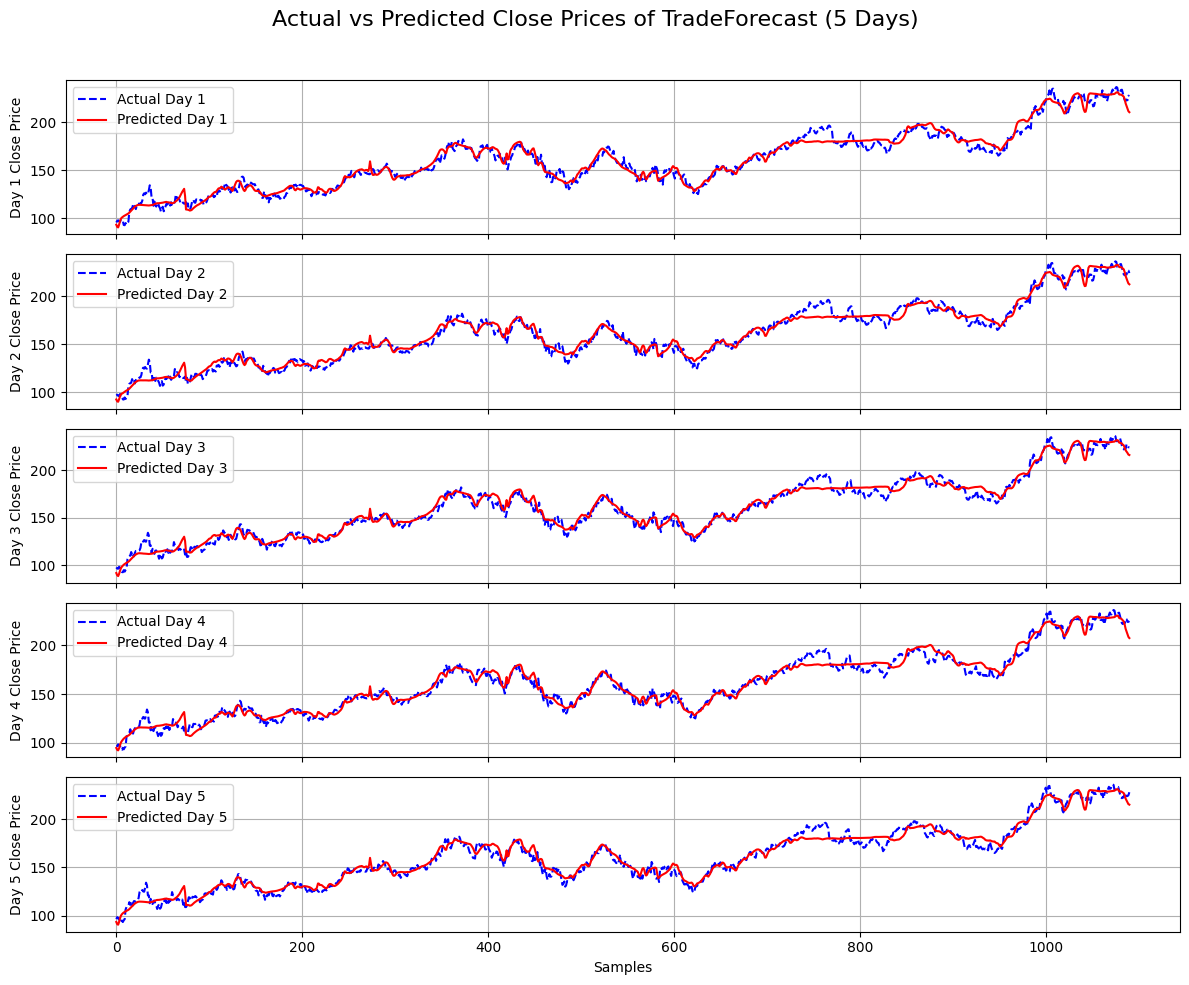

In [7]:
from tradeforecast.viz import plot_rnn_forecasts

plot_rnn_forecasts(y_arr, y_preds_arr)